In [45]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## Define input function

First we define input function for the XOR problem. Signal is represented as a convolution of a waveform and a carrier wave. For signal 'zero' the waveform is defined as exp(iwt), where w corresponds to the bit-rate. The waveform of the signal 'one' is the same but shifted by pi/2.

In [73]:
bit_rate = 0.125*10**9 #Hz
signal_duration = 1/bit_rate
print("signal duration is equal to", round(signal_duration*10**12), "ps")

signal duration is equal to 8000 ps


C:\Users\ekate\AppData\Local\Temp\ipykernel_12840\1888267122.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


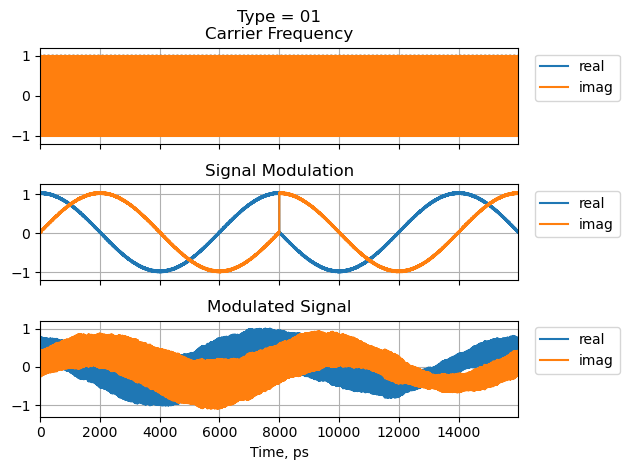

In [62]:
def input_noise(ty, figur = "No"):
    """ty = "11", "10", "01", or "00"
    returns modulated signal as a 1D array of complex numbers
    0 and 1 are different by pi/2
    """
    bit_rate = 0.125*10**9 #Hz
    signal_duration = round(1/bit_rate*10**12)
    t = np.arange(0,2*signal_duration)*10**(-12) #2*8000 ps

    #carier wave characteristics
    lam = 1531*10**(-9) #m
    c = 3*10**8 #m/s
    f = c/lam
    w = 2*np.pi*f
    sig = np.exp(1.0j*w*t)

    #waveform characteristics
    bit_s = 0.125*10**9 #bit per second
    f_wf = bit_s
    w_wf = 2*np.pi*f_wf
    sign_len = 8000
    one = np.exp(1.0j*(w_wf*t[0:sign_len]+np.pi/2))
    zero = np.exp(1.0j*w_wf*t[0:sign_len])
    noise_max = 0.05
    noise = np.random.rand(16000)*noise_max+1.0j*np.random.rand(16000)*noise_max
    if ty == "01":
        win = np.concatenate((zero,one))+noise
    if ty == "11":
        win = np.concatenate((one,one))+noise
    if ty == "00":
        win = np.concatenate((zero,zero))+noise
    if ty == "10":
        win = np.concatenate((one,zero))+noise

    filtered = signal.convolve(sig, win, mode='same') #convolution of the waveform and the carrier wave
    filtered = filtered / max(filtered)
    
    if (figur == "yes"):
        fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
        ax_orig.plot(np.real(sig), label = 'real')
        ax_orig.plot(np.imag(sig), label = 'imag')
        ax_orig.set_title(f'Type = {ty}\nCarrier Frequency')
        ax_orig.margins(0, 0.1)
        ax_orig.grid()
        ax_orig.legend(bbox_to_anchor=(1.02, 1.0))
        ax_win.plot(np.real(win), label = 'real')
        ax_win.plot(np.imag(win), label = 'imag')
        ax_win.set_title('Signal Modulation')
        ax_win.margins(0, 0.1)
        ax_win.grid()
        ax_win.legend(bbox_to_anchor=(1.02, 1.0))
        ax_filt.plot(np.real(filtered), label = 'real')
        ax_filt.plot(np.imag(filtered), label = 'imag')
        ax_filt.set_title('Modulated Signal')
        ax_filt.margins(0, 0.1)
        ax_filt.grid()
        ax_filt.set_xlabel('Time, ps')
        ax_filt.legend(bbox_to_anchor=(1.02, 1.0))
        fig.tight_layout()
        fig.show()

    return filtered
i = input_noise("01","yes")

Then we add delay function, corresponding to the light propagation through the delay line. The time delay is 280 ps, and since we know approximately the refractive index, we can compute the phase shift. The losses are taken from the paper.

C:\Users\ekate\AppData\Local\Temp\ipykernel_12840\1403846740.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


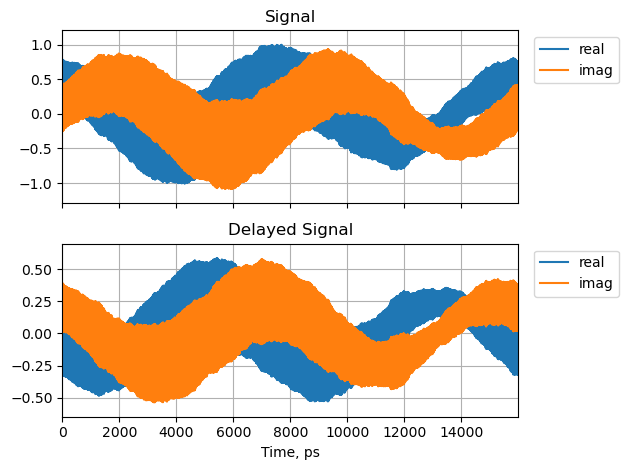

In [65]:
def delay(signal, t_delay = 280*10**(-9), figur = "No"):
    """
    takes a complex number (or array) and propagates it through the wg
    """
    c = 3*10**8 #m/s
    n = 2
    phase_velocity = c/n
    dPhi = phase_velocity*t_delay
    alpha = 1.2 #dB/spiral
    delayed = np.exp(-alpha/2)*np.exp(-1.0j*dPhi)*signal
    if (figur == "yes"):
        fig, (ax_signal, ax_delayed) = plt.subplots(2, 1, sharex=True)

        ax_signal.plot(np.real(signal), label = 'real')
        ax_signal.plot(np.imag(signal), label = 'imag')
        ax_signal.set_title(f'Signal')
        ax_signal.margins(0, 0.1)
        ax_signal.grid()
        ax_signal.legend(bbox_to_anchor=(1.02, 1.0))
        ax_delayed.plot(np.real(delayed), label = 'real')
        ax_delayed.plot(np.imag(delayed), label = 'imag')
        ax_delayed.set_title('Delayed Signal')
        ax_delayed.margins(0, 0.1)
        ax_delayed.grid()
        ax_delayed.legend(bbox_to_anchor=(1.02, 1.0))
        ax_delayed.set_xlabel("Time, ps")
        fig.tight_layout()
        fig.show()
    
    return delayed

d = delay(i, figur = "yes")

Finally, the scheme16() function connects all the nodes with respecting direction of the light and delays. The nodes scheme was taken from the paper. First 1000 ps is equal to zero at all nodes for convenience of computations. Then the input starts propagatng to the 5th node, from which it is directed to the 1th and the 6th nodes with delays. The system is described as a system of equations and apdated every 1 ps. The results that propagate further to the detectors are taken from all the 16 nodes and are saved from the 1000 ps to 5000 ps. The whole simulation is up to 5000 ps.

C:\Users\ekate\AppData\Local\Temp\ipykernel_12840\3127752044.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


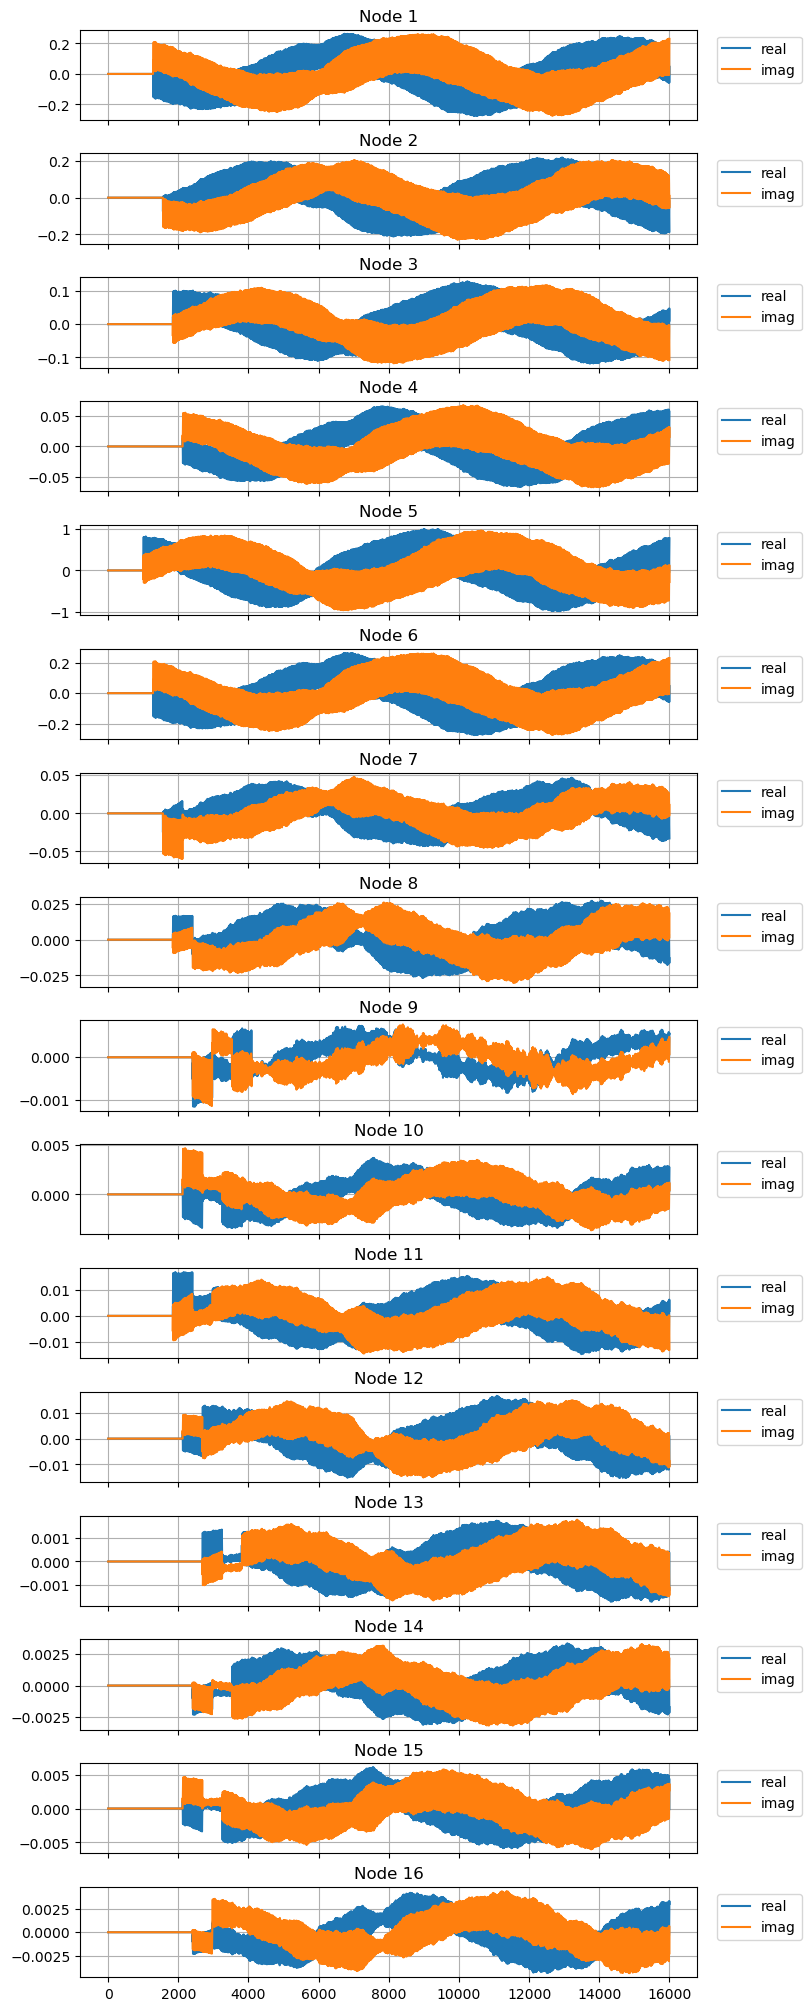

In [78]:
def scheme16_noise(ty, figur = "No"):
    """
      number of nodes is 16, they are connected in the way of the paper
      this function connects the nodes according to the scheme and specifies all delays
      the output is 16d array of length of 15000 ps
    """
    start = 1000
    end = 16000
    t_delay = 280 #ps
    t_arr = np.arange(0,end) #5000 ps
    #initial conditions
    input_ar = input_noise(ty)
    # for the first 1000 ps the nodes are equal to 0. It is needed to ease the adress to n4[i-280]
    
    n1 = n2 = n3 = n4 = n5 = n6 = n7 = n8 = n9 = n10 = n11 = n12 = n13 = n14 = n15 = n16 = np.zeros(start)
    
    #input_ar = np.concatenate((input_ar,np.zeros(end))) # and input array is zero after it ends

    for i in range(start,end):
        n1 = np.concatenate((n1, np.array([delay(1/2*n5[i-1-t_delay])])))
        n2 = np.concatenate((n2, np.array([delay(n1[i-1-t_delay])+1/2*delay(n6[i-1-t_delay])])))
        n3 = np.concatenate((n3, np.array([delay(n2[i-1-t_delay])])))
        n4 = np.concatenate((n4, np.array([delay(n3[i-1-t_delay])])))
        n5 = np.concatenate((n5, np.array([input_ar[i-start]+delay(n9[i-1-t_delay])])))
        n6 = np.concatenate((n6, np.array([delay(1/2*n5[i-1-t_delay])+delay(1/2*n10[i-1-t_delay])])))
        n7 = np.concatenate((n7, np.array([delay(1/2*n3[i-1-t_delay])+delay(1/2*n6[i-1-t_delay])])))
        n8 = np.concatenate((n8, np.array([delay(n4[i-1-t_delay])+delay(1/2*n7[i-1-t_delay])])))
        n9 = np.concatenate((n9, np.array([delay(1/2*n10[i-1-t_delay])+delay(n13[i-1-t_delay])])))
        n10 = np.concatenate((n10, np.array([delay(1/2*n11[i-1-t_delay])+delay(1/2*n14[i-1-t_delay])])))
        n11 = np.concatenate((n11, np.array([delay(1/2*n7[i-1-t_delay])+delay(1/2*n12[i-1-t_delay])])))
        n12 = np.concatenate((n12, np.array([delay(n8[i-1-t_delay])])))
        n13 = np.concatenate((n13, np.array([delay(n14[i-1-t_delay])])))
        n14 = np.concatenate((n14, np.array([delay(n15[i-1-t_delay])])))
        n15 = np.concatenate((n15, np.array([delay(1/2*n11[i-1-t_delay])+delay(n16[i-1-t_delay])])))
        n16 = np.concatenate((n16, np.array([delay(1/2*n12[i-1-t_delay])])))
    
    nn = (n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15,n16)
    if (figur == "yes"):
        plt.rcParams['figure.figsize'] = [8, 20]
        fig, nn_axes = plt.subplots(16, 1, sharex=True, layout="constrained")
        for i,ax in enumerate (nn_axes):
            ax.plot(np.real(nn[i]), label = 'real')
            ax.plot(np.imag(nn[i]), label = 'imag')
            ax.set_title(f'Node {i+1}')
            ax.grid()
            ax.legend(bbox_to_anchor=(1.02, 1.0))
        fig.show()
        
    return np.reshape(np.concatenate((n1[start:],n2[start:],n3[start:],n4[start:],n5[start:],n6[start:],n7[start:],n8[start:],n9[start:],n10[start:],n11[start:],n12[start:],n13[start:],n14[start:],n15[start:],n16[start:])),(-1,end-start))

s = scheme16_noise("01",figur = "yes")

Once the system is computed it is the time to put it through nonlinear activaation, which is done by a nonlinearity() function. It adds the square of real and imaganery part of the complex number or array.

In [80]:
def nonlinearity(x):
  """
  takes array of complex numbers and converts it nonlinearly to array of the same shape of real numbers
  """
  return abs(x)**2

Finally, the dl_input function connects all functions and makes an appropriate input to the input layer of the Neural Network.

In [81]:
def dl_input(n):
    '''
    takes a number of samples of each type
    returns x_train and y_train for the NN model
    '''
    #making n arrays of each type for the problem
    s00 = np.array([scheme16_noise('00') for i in range(0,n)])
    s10 = np.array([scheme16_noise('10') for i in range(0,n)])
    s01 = np.array([scheme16_noise('01') for i in range(0,n)])
    s11 = np.array([scheme16_noise('11') for i in range(0,n)])

    #making n simulations of each type
    labels00 = labels11 = [[0,1] for i in range(0,n)]
    labels01 = labels10 = [[1,0] for i in range(0,n)]

    x = np.concatenate((s00,s01,s10,s11))
    y = np.concatenate((labels00,labels01,labels10,labels11))
    x = nonlinearity(x)
    y = nonlinearity(y)
    
    return x, y

## NN model creation

In [48]:
#import libraries for NN model
import tensorflow as tf
from sklearn.model_selection import KFold

To avoid overfitting we use K-Folds cross-validator

In [82]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
X,y = dl_input(30) #make dataset and labels 30 sample for each type

In [84]:
#The model itself with cross-validation technique
for train_index, test_index in kfold.split(X):     
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = tf.keras.Sequential([                     #model has one hidden layer with relu activation function
    tf.keras.layers.Flatten(input_shape=(16, 15000)), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid') 
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
3/3 - 1s - loss: 0.8439 - accuracy: 0.5208 - 648ms/epoch - 216ms/step
Epoch 2/100
3/3 - 0s - loss: 0.5270 - accuracy: 0.8542 - 157ms/epoch - 52ms/step
Epoch 3/100
3/3 - 0s - loss: 0.4590 - accuracy: 0.9062 - 176ms/epoch - 59ms/step
Epoch 4/100
3/3 - 0s - loss: 0.4110 - accuracy: 0.8958 - 170ms/epoch - 57ms/step
Epoch 5/100
3/3 - 0s - loss: 0.3813 - accuracy: 0.8958 - 172ms/epoch - 57ms/step
Epoch 6/100
3/3 - 0s - loss: 0.3694 - accuracy: 0.8958 - 152ms/epoch - 51ms/step
Epoch 7/100
3/3 - 0s - loss: 0.3590 - accuracy: 0.9167 - 145ms/epoch - 48ms/step
Epoch 8/100
3/3 - 0s - loss: 0.3470 - accuracy: 0.9062 - 146ms/epoch - 49ms/step
Epoch 9/100
3/3 - 0s - loss: 0.3419 - accuracy: 0.8854 - 160ms/epoch - 53ms/step
Epoch 10/100
3/3 - 0s - loss: 0.3451 - accuracy: 0.8958 - 155ms/epoch - 52ms/step
Epoch 11/100
3/3 - 0s - loss: 0.3262 - accuracy: 0.9167 - 159ms/epoch - 53ms/step
Epoch 12/100
3/3 - 0s - loss: 0.3186 - accuracy: 0.9062 - 152ms/epoch - 51ms/step
Epoch 13/100
3/3 - 0s - 

Model accuracy reaches 98.86% on the training data. We then evaluate the model accuracy by preparing another dataset with 10 samples of each type.

In [85]:
x_eval,  y_eval = dl_input(10)
model.evaluate(x_eval,  y_eval)

2/2 [==============================] - 0s 6ms/step - loss: 0.4080 - accuracy: 0.9000


[0.40802431106567383, 0.8999999761581421]

Evaluation shows accuracy = 0,9 which is a high bar for reservoir computing and temporal XOR problem. Now we know that prediction will give 9 out of 10 outputs to our reservoir samples correctly. The results are quite promising considering that we added the noise of 5% and that the NN model had only one hidden layer. Thus the reservoir did help the model to solve the XOR problem.